In [2]:
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, mapping
import geopandas as gpd
import json
from ipyleaflet import *

In [3]:
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
# load graph from disk and confirm 'w3' edge attribute is there
graph = ox.load_graphml('graph.graphml')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4304\2815683300.py:3: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


In [50]:
import osmnx as ox

# load thiruvananthapuram city
place = "Thiruvananthapuram, Kerala"
G = ox.graph_from_place(place, network_type="drive")

# kazhakootam coordinates
kzh_lat, kzh_lon = 8.5686, 76.8731
# medical college coordinates
mdcl_lat, mdcl_lon = 8.52202892500963, 76.926448394559

# fetch the nearest node w.r.t coordinates
kzh_node = ox.distance.nearest_nodes(G, kzh_lon, kzh_lat)
mdcl_node = ox.distance.nearest_nodes(G, mdcl_lon, mdcl_lat)

print("Kazhakkottam Node: {kzh_node}, \
Medical College Node: {mdcl_node}".format(
    kzh_node=kzh_node, mdcl_node=mdcl_node))

Kazhakkottam Node: 1141007999, Medical College Node: 9992653265


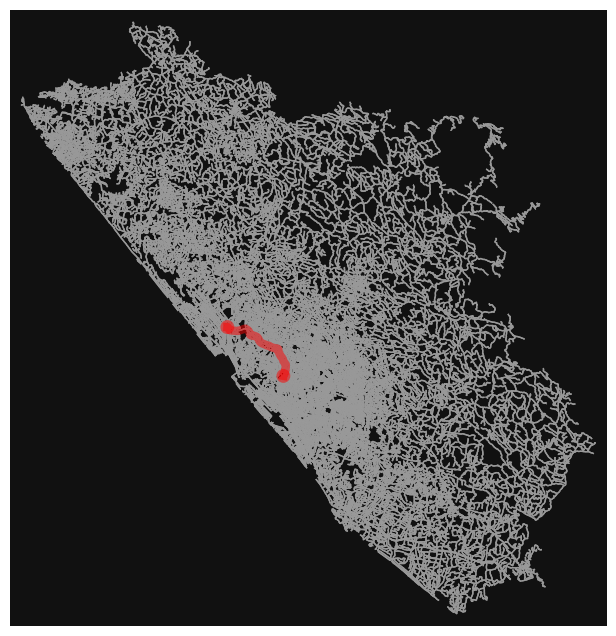

In [51]:
# orgin node and destination node
orig, dest = 1141007999, 9992653265

# find shortest path
route_nodes = ox.routing.shortest_path(G, kzh_node, mdcl_node, weight="length")

# plot the shortes path
fig, ax = ox.plot_graph_route(G, route_nodes, route_color="r", 
                              route_linewidth=6, node_size=0)

In [5]:
nodes, edges = ox.graph_to_gdfs(graph)

In [6]:
nodes

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
420510938,16.360842,107.734266,3,NaN,NaN,POINT (107.73427 16.36084)
420511052,16.326745,107.761064,3,NaN,NaN,POINT (107.76106 16.32675)
619882796,16.351854,107.447260,3,NaN,NaN,POINT (107.44726 16.35185)
619882820,16.353934,107.447636,3,NaN,NaN,POINT (107.44764 16.35393)
619882907,16.350126,107.497511,3,NaN,NaN,POINT (107.49751 16.35013)
...,...,...,...,...,...,...
11765959173,16.569359,107.384239,3,NaN,NaN,POINT (107.38424 16.56936)
11765959174,16.572210,107.383704,3,NaN,NaN,POINT (107.38370 16.57221)
11765959175,16.570777,107.382703,3,NaN,NaN,POINT (107.38270 16.57078)


In [44]:
center = (16.4683,107.5786)

m = Map(center=center, basemap=basemaps.CartoDB.Positron, zoom=15)
m

Map(center=[16.4683, 107.5786], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [45]:
to_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='red',
    spin=False
)

from_marker = Marker(location=center)
to_marker = Marker(location=(16.4531082, 107.5449069), icon=to_marker_style)

In [46]:
def set_nearest_node(marker):
    marker.nearest_node = ox.nearest_nodes(graph, marker.location[0],marker.location[1])
    return

In [47]:
path_layer_list = []

def handle_change_location(event, marker):
    event_owner = event['owner']
    print(event_owner.location)
    event_owner.nearest_node = ox.nearest_nodes(graph, event_owner.location[0],event_owner.location[1])
    marker.neares_node = ox.nearest_nodes(graph, marker.location[0],marker.location[1])
    
    shortest_path = nx.dijkstra_path(graph, event_owner.nearest_node, marker.neares_node, 
                                     weight='length')
    print(shortest_path)
    if len(path_layer_list) == 1:
        m.remove_layer(path_layer_list[0])
        path_layer_list.pop()
    
    shortest_path_points = nodes.loc[shortest_path]
    path = gpd.GeoDataFrame([LineString(shortest_path_points.geometry.values)], columns=['geometry'])
    path_layer = GeoData(geo_dataframe=path, style={'color':'black', 'weight':2})
    m.add_layer(path_layer)
    path_layer_list.append(path_layer)
    print(shortest_path)
    
    
from_marker.observe(lambda event: handle_change_location(event, to_marker), 'location')
to_marker.observe(lambda event: handle_change_location(event, from_marker), 'location')

In [48]:
m.add_layer(from_marker)
m.add_layer(to_marker)
set_nearest_node(from_marker)
set_nearest_node(to_marker)
m

Map(center=[16.4683, 107.5786], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [49]:
handle_change_location(event, from_marker)

NameError: name 'event' is not defined